## Credit Card Fraud Detection 
Three predictive models to see how accurate they are in detecting whether a transaction is legit or fraud.
- Support vector machine
- Random Forest
- Logistic Regression
Two Approaches are applied to handle the inbalanced dataset
- Undersampling
- Oversampling, to be specific, SMOTE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [3]:
creditCard = pd.read_csv('gs://project271/creditcard.csv', sep=",")

In [4]:
creditCard.shape

(284807, 31)

In [5]:
creditCard['Amount'].mean()

88.34961925087359

In [6]:
creditCard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
creditCard[creditCard.Class == 1].shape[0]/creditCard.shape[0]

0.001727485630620034

In [8]:
creditCard[creditCard.Class == 1].shape

(492, 31)

0    284315
1       492
Name: Class, dtype: int64


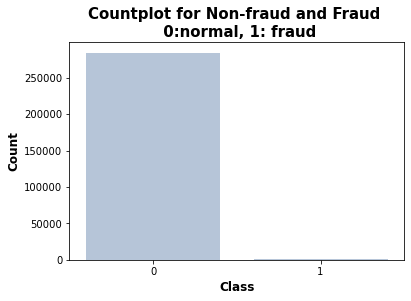

In [9]:
print(creditCard["Class"].value_counts())
#plt.style.use('dark_background')
sns.countplot("Class",data=creditCard,color="lightsteelblue")
plt.xlabel("Class", fontSize = 12, fontWeight = 'bold')
plt.ylabel("Count", fontSize = 12, fontWeight = 'bold')
plt.title("Countplot for Non-fraud and Fraud \n 0:normal, 1: fraud", fontSize = 15, fontWeight = 'bold')
plt.show()

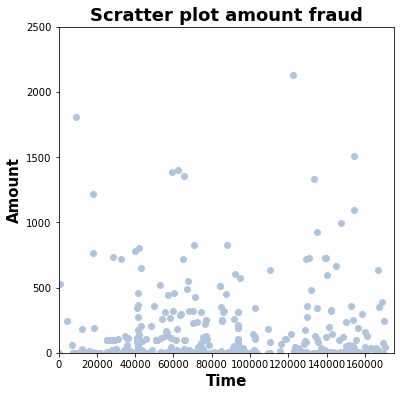

In [10]:
## fraud data visualization
creditCard_fraud = creditCard[creditCard.Class == 1]
plt.figure(figsize=(6,6))
plt.scatter(creditCard_fraud['Time'], creditCard_fraud['Amount'],color = "lightsteelblue") # Display fraud amounts according to their time
plt.title('Scratter plot amount fraud', fontSize = 18, fontWeight = "bold")
plt.xlabel('Time',fontSize = 15, fontWeight = "bold")
plt.ylabel('Amount',fontSize = 15, fontWeight = "bold")
plt.xlim([0,175000])
plt.ylim([0,2500])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f02dd19fcd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f02dd1303d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f02dd19f970>],
 'medians': [<matplotlib.lines.Line2D at 0x7f02dd130a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f02dd130d90>],
 'means': []}

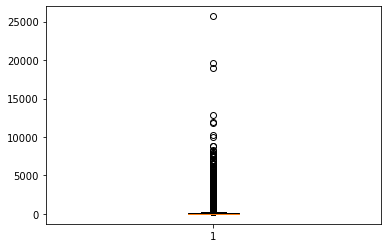

In [11]:
plt.boxplot(creditCard['Amount'])

(array([2.84395e+05, 3.60000e+02, 3.60000e+01, 1.00000e+01, 2.00000e+00,
        1.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([    0.   ,  2569.116,  5138.232,  7707.348, 10276.464, 12845.58 ,
        15414.696, 17983.812, 20552.928, 23122.044, 25691.16 ]),
 <a list of 10 Patch objects>)

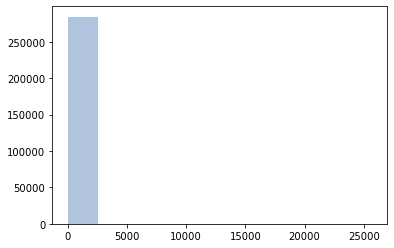

In [12]:
plt.hist(x = creditCard['Amount'],color = "lightsteelblue")

In [13]:
#### check if remove the extreme value in outlier will improve the accuracy
creditCard[creditCard['Amount']> 10000]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
46841,42951.0,-23.712839,-42.172688,-13.320825,9.925019,-13.945538,5.564891,15.710644,-2.844253,-1.580725,...,7.921600,-6.320710,-11.310338,0.404175,-4.547278,-1.577118,-2.357385,2.253662,12910.93,0
54018,46253.0,-21.780665,-38.305310,-12.122469,9.752791,-12.880794,4.256017,14.785051,-2.818253,-0.667338,...,7.437478,-5.619439,-10.547038,0.653249,-4.232409,-0.480459,-2.257913,2.082488,11898.09,0
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,...,11.455313,-10.933144,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0
151296,95286.0,-34.549296,-60.464618,-21.340854,16.875344,-19.229075,6.335259,24.422716,-4.964566,0.188912,...,11.502580,-9.499423,-16.513186,0.744341,-7.081325,-2.604551,-3.550963,3.250802,18910.00,0
169457,119713.0,-20.924897,-37.943452,-14.060281,10.473005,-10.866639,6.256654,14.960521,-2.392155,-0.597076,...,6.829810,-6.926353,-9.928657,-0.447084,-4.848151,-2.241620,-2.140723,2.001492,11789.84,0
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,...,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0
284249,172273.0,-9.030538,-11.112584,-16.233798,3.592021,-40.427726,23.917837,44.054461,-7.277778,-4.210637,...,-0.269048,0.988144,7.040028,0.347693,2.520869,2.342495,3.478175,-2.713136,10199.44,0


Note that there are several extreme data existing in the dataset, when choosing scaler method, we will choose robust scaler to transform the amount and time

In [14]:
scaler = RobustScaler()
creditCard["scaledAmount"] = scaler.fit_transform(creditCard['Amount'].values.reshape(-1,1))
creditCard["scaledTime"] = scaler.fit_transform(creditCard['Time'].values.reshape(-1,1))  

In [15]:
creditCard["scaledAmount"].head()

0    1.783274
1   -0.269825
2    4.983721
3    1.418291
4    0.670579
Name: scaledAmount, dtype: float64

In [16]:
creditCard["scaledAmount"].max()

358.6831551736184

{'whiskers': [<matplotlib.lines.Line2D at 0x7f02dd2078b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f02dda5cbe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f02dd207790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f02dd1f47c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f02dd1f4c70>],
 'means': []}

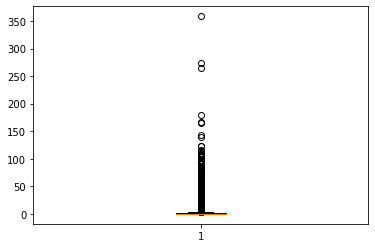

In [17]:
plt.boxplot(creditCard["scaledAmount"])

In [18]:
creditCard[creditCard["scaledAmount"]>150]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaledAmount,scaledTime
46841,42951.0,-23.712839,-42.172688,-13.320825,9.925019,-13.945538,5.564891,15.710644,-2.844253,-1.580725,...,-11.310338,0.404175,-4.547278,-1.577118,-2.357385,2.253662,12910.93,0,180.101027,-0.490384
54018,46253.0,-21.780665,-38.305310,-12.122469,9.752791,-12.880794,4.256017,14.785051,-2.818253,-0.667338,...,-10.547038,0.653249,-4.232409,-0.480459,-2.257913,2.082488,11898.09,0,165.948299,-0.451591
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,...,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0,274.359394,-0.426356
151296,95286.0,-34.549296,-60.464618,-21.340854,16.875344,-19.229075,6.335259,24.422716,-4.964566,0.188912,...,-16.513186,0.744341,-7.081325,-2.604551,-3.550963,3.250802,18910.00,0,263.927898,0.124461
169457,119713.0,-20.924897,-37.943452,-14.060281,10.473005,-10.866639,6.256654,14.960521,-2.392155,-0.597076,...,-9.928657,-0.447084,-4.848151,-2.241620,-2.140723,2.001492,11789.84,0,164.435688,0.411436
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,...,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0,358.683155,0.957554


robustscaler is robust to outliers, after scaling the data, the extrem data in the original dataset still exist in the transformed data.

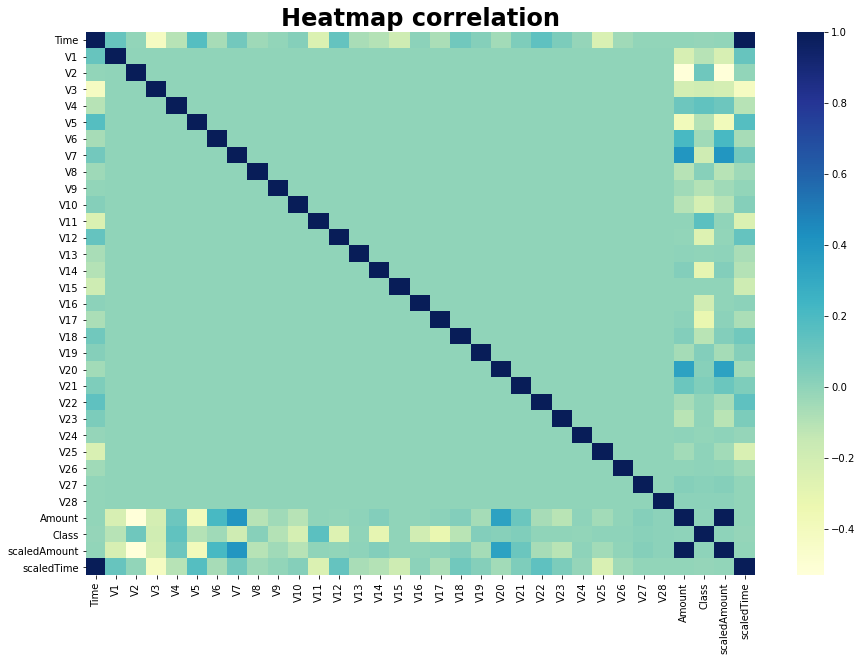

In [19]:
creditCard_corr = creditCard.corr()
## heatmap
plt.figure(figsize=(15,10))
sns.heatmap(creditCard_corr, cmap="YlGnBu") # Displaying the Heatmap
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation', fontWeight = "bold")
plt.show()

In [20]:
## check null value
creditCard.isnull().values.any()

False

In [21]:
## drop original amount and time variables
creditCard = creditCard.drop(["Amount", "Time"], axis = 1)

It is suggested on kaggle website, it is not wise to test using samling data. We should split data before sampling data.


In [22]:
creditCard.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaledAmount', 'scaledTime'],
      dtype='object')

In [23]:
## splitting data before sampling
x = creditCard.drop("Class", axis = 1)
y = creditCard["Class"]

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for trainIndex, testIndex in skf.split(x, y):
    print("TRAIN:", trainIndex, "TEST:", testIndex)
    xTrainBefore, xTestBefore = x.iloc[trainIndex], x.iloc[testIndex]
    yTrainBefore, yTestBefore = y.iloc[trainIndex], y.iloc[testIndex]

TRAIN: [ 30473  30496  31002 ... 284804 284805 284806] TEST: [    0     1     2 ... 57017 57018 57019]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 30473  30496  31002 ... 113964 113965 113966]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 81609  82400  83053 ... 170946 170947 170948]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [150654 150660 150661 ... 227866 227867 227868]
TRAIN: [     0      1      2 ... 227866 227867 227868] TEST: [212516 212644 213092 ... 284804 284805 284806]


We want the same proportion of fraud transation and normal transaction in test set and train set. 

In [24]:
yTestBefore.shape

(56961,)

Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]
[0.99827076 0.00172924]


Text(0.5, 1.0, 'non-fraud percentage')

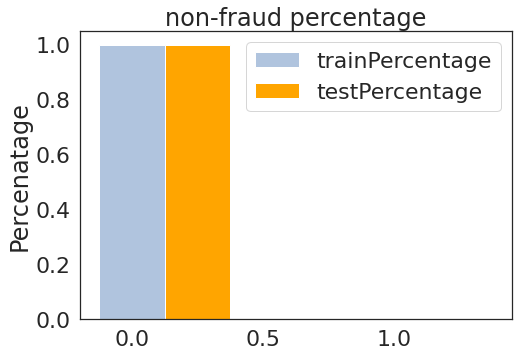

In [25]:
xTrainBeforeVal = xTrainBefore.values
xTestBeforeVal = xTestBefore.values
yTrainBeforeVal = yTrainBefore.values
yTestBeforeVal = yTestBefore.values

trainLabel, trainCounts = np.unique(yTrainBeforeVal, return_counts=True)
testLabel, testCounts = np.unique(yTestBeforeVal, return_counts=True)

print('Label Distributions: \n')
print(trainCounts/ len(yTrainBeforeVal))
print(testCounts/ len(yTestBeforeVal))

trainPortion = trainCounts/ len(yTrainBeforeVal)
print(trainPortion)
testPortion = testCounts/ len(yTestBeforeVal)
X = np.arange(2)
##  show in barchart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, trainPortion, color = 'lightsteelblue', width = 0.25)
ax.bar(X + 0.25, testPortion, color = 'orange', width = 0.25)
ax.legend(labels=['trainPercentage', 'testPercentage'])
ax.set_ylabel("Percenatage")
ax.set_title("non-fraud percentage")

Fraud transcation and non fraud transaction are almost the same proportion in training dataset and testing dataset.

In [26]:
## select fraud credit card
fraud = creditCard[creditCard['Class'] == 1]
fraud.shape
#creditCard = creditCard.sample(frac = 1)

(492, 31)

In [27]:
##shuffle the data and pick the first nonfraud
creditCard = creditCard.sample(frac = 1)
normal = creditCard[creditCard["Class"]== 0]
normal.shape

(284315, 31)

In [28]:
normal = normal[:492]
normal.shape

(492, 31)

In [29]:
creditCardUndersample = pd.concat([normal, fraud])
creditCardUndersample.shape

(984, 31)

In [30]:
creditCardUndersample.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaledAmount,scaledTime
49137,-1.077363,-0.178269,1.822364,-2.651625,-1.256171,0.429907,-1.092396,0.922511,-2.411848,0.726477,...,0.496215,-0.169802,-0.330829,0.224157,-0.122057,0.207510,0.041512,0,-0.120170,-0.478918
88517,0.712492,-1.306759,0.707780,0.206644,-1.170738,0.636621,-0.659598,0.401527,1.201711,-0.380484,...,-0.507640,-0.120460,-0.257493,-0.064268,0.956583,-0.075395,0.032945,0,2.956194,-0.264559
257640,-0.343188,1.294469,-0.992352,-1.312997,1.364124,-1.227211,1.757482,-0.510755,0.299575,0.371045,...,0.755608,-0.229302,0.615265,-0.253441,0.049651,0.433116,0.167680,0,-0.296653,0.864425
177588,1.975045,-0.218468,-0.903490,-0.002687,-0.057393,-0.397181,-0.182396,0.007299,0.293798,0.236864,...,-1.275540,0.575690,0.647104,-0.764803,-0.030526,-0.077524,-0.049197,0,-0.032558,0.452931
17051,-0.959647,1.238004,0.761621,-1.062770,0.051567,-1.165058,0.749602,0.282329,-0.623989,-0.845586,...,-1.299087,0.035710,0.019137,-0.154825,0.522548,0.081838,0.078667,0,-0.139873,-0.661356


Due to concatnation, the first half is fraud, and the next half is normal data, so it's better to shuffle the data.

In [31]:
creditCardUndersample = creditCardUndersample.sample(frac = 1)

In [32]:
creditCardUndersample["Class"].head()

237107    1
139284    0
198586    0
227919    0
149577    1
Name: Class, dtype: int64

OK, now it is mixed fraud and non-fradu together

Text(0.5, 1.0, 'Fraud Counts vs non-Fraud Counts')

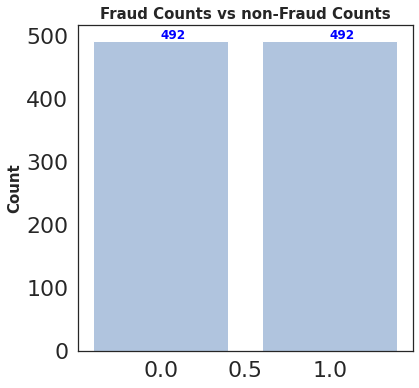

In [33]:
## plot the propotion of data in the bar plot
size = creditCardUndersample.groupby('Class')["Class"].size()
plt.figure(figsize=(6,6))
plt.bar(list(creditCardUndersample["Class"].unique()),creditCardUndersample.groupby('Class')["Class"].size(),color = "lightsteelblue")
plt.text(0, size[0]+2,str(size[0]), color='blue', fontweight='bold',fontSize = 12 )
plt.text(1.0, size[1]+2,str(size[1]), color='blue', fontweight='bold', fontSize = 12)
plt.ylabel("Count", fontsize = 15,fontweight = 'bold')
plt.title("Fraud Counts vs non-Fraud Counts", fontsize = 15, fontweight = 'bold')

Text(0, 0.5, 'Scaled Amount')

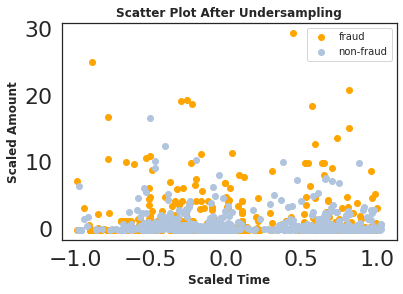

In [34]:
## let's see how the new data look like
## scatter plot
#creditCardUndersample.columns

fig, ax = plt.subplots()
color = ["orange", 'lightsteelblue']
#plt.scatter(creditCardUndersample['scaledTime'],creditCardUndersample['scaledAmount'], c = creditCardUndersample['Class'])
plt.scatter(fraud['scaledTime'] , fraud['scaledAmount'],c= color[0])
plt.scatter(normal['scaledTime'], normal['scaledAmount'],c = color[1])
ax.legend(labels = ["fraud", "non-fraud"], fontsize = 10)
ax.set_title("Scatter Plot After Undersampling", fontsize = 12,fontweight = 'bold')
ax.set_xlabel("Scaled Time", fontsize = 12,fontweight = 'bold')
ax.set_ylabel("Scaled Amount", fontsize = 12,fontweight = 'bold')

Text(0.5, 1.0, 'Fraud and non-Fraud boxplot')

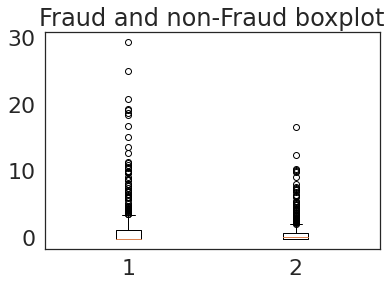

In [35]:
data = [fraud['scaledAmount'],normal['scaledAmount']]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_title("Fraud and non-Fraud boxplot")

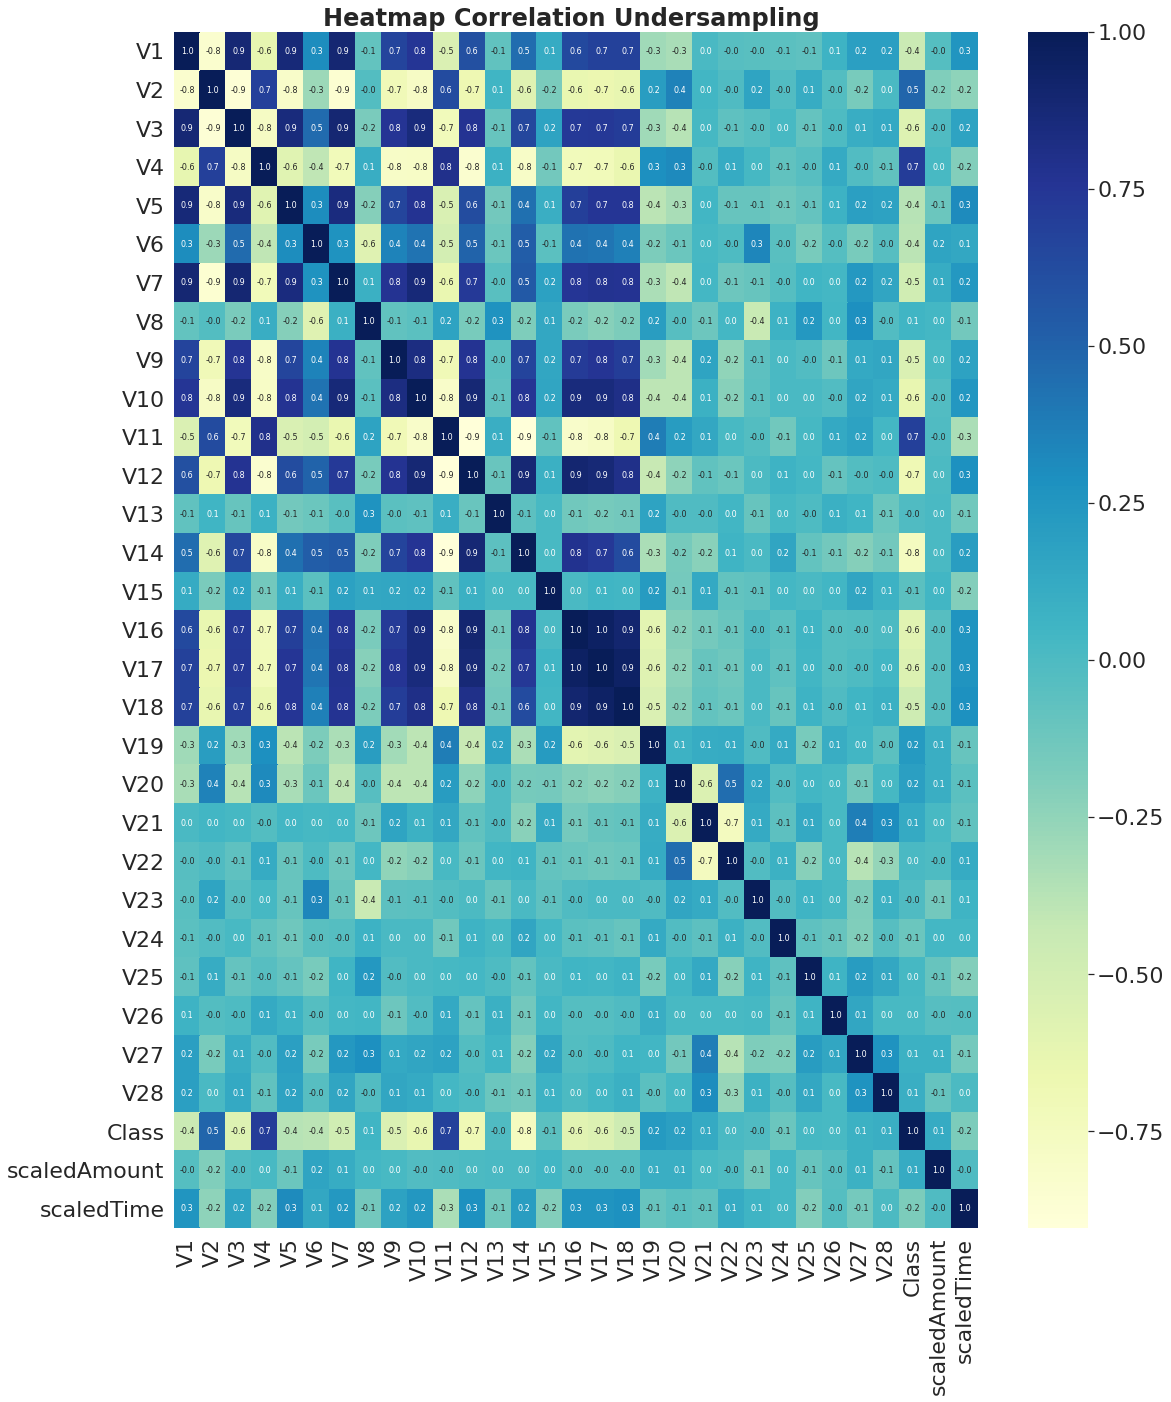

In [36]:
## heatmap
corrUnder = creditCardUndersample.corr()
#plt.figure(figsize=(15,10))
#ax = plt.axes(figsize=(15,10))
#sns.heatmap(corrUnder)
#sns.set(font_scale=0.1,style='white')
#ax.set_title("Heat Map", fontsize = 20, fontweight = 'bold')

## heatmap
plt.figure(figsize=(18,22))
sns.heatmap(corrUnder, cmap="YlGnBu",annot=True,fmt=".1f",annot_kws={'size':8},) # Displaying the Heatmap
sns.set(font_scale=2,style='white')

plt.title('Heatmap Correlation Undersampling ',fontWeight = "bold")
plt.show()

After checking heatmap,delete V1, V3, V10, V11, V14, V16 and v18

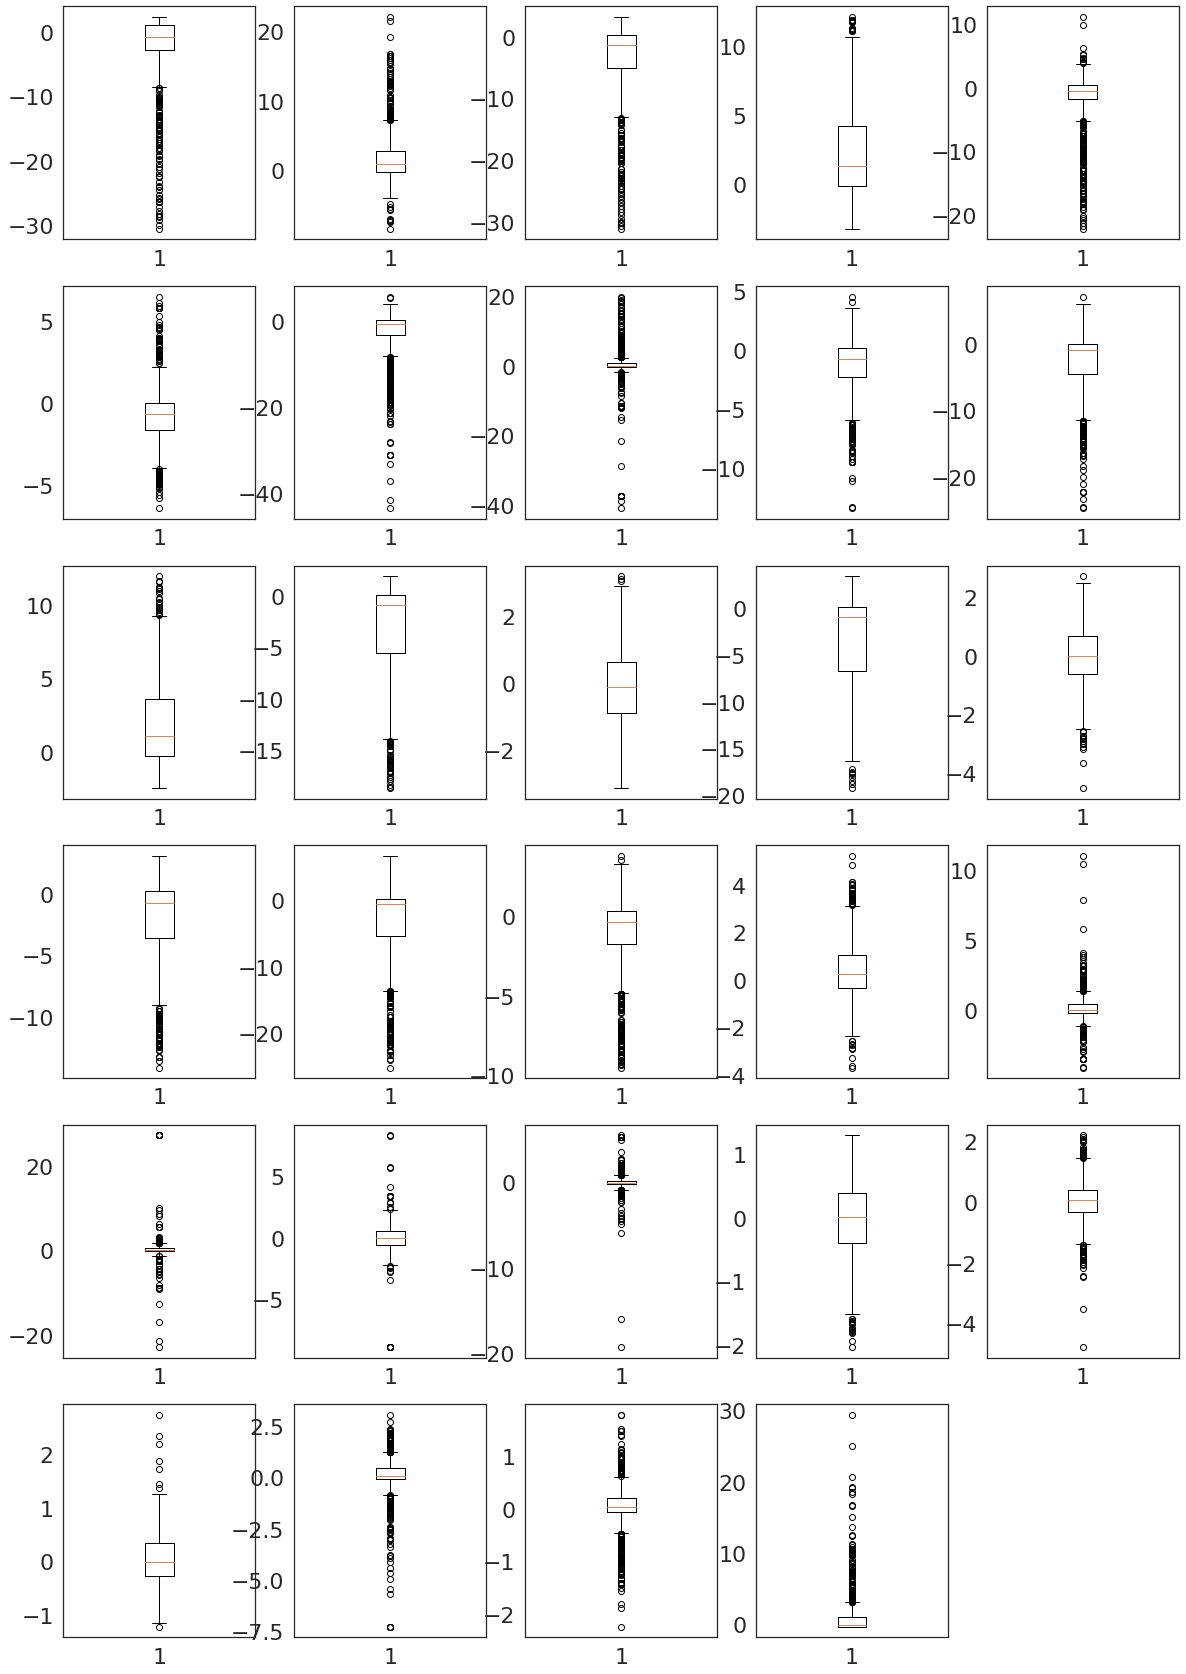

In [37]:
col_dict = {'V1':1, 'V2':2, 'V3':3,'V4':4, 'V5':5,'V6':6, 'V7':7, 'V8':8, 'V9':9, 'V10':10, 'V11':11, 'V12':12, 
            'V13':13, 'V14':14, 'V15':15, 'V16':16, 'V17': 17, 'V18':18, 'V19':19, 'V20':20, 'V21':21,'V22':22,
           'V23':23, 'V24':24, 'V25':25, 'V26':26,'V27':27, 'V28':28,'scaledAmount':29}
plt.figure(figsize = (20,30))
for variable, i in col_dict.items():
    plt.subplot(6,5,i)
    plt.boxplot(creditCardUndersample[variable])
plt.show()

In [38]:
## split the data,test case 80%
creditCardUndersampleX = creditCardUndersample.drop("Class",axis = 1)
creditCardUndersampleY = creditCardUndersample['Class']
xTrain,xTest,yTrain, yTest = train_test_split(creditCardUndersampleX, creditCardUndersampleY, test_size=0.2, random_state=0)  

In [39]:
## support vector machine
clf = svm.SVC(kernel='linear', C=1).fit(xTrain, yTrain)
trainingScore = cross_val_score(clf, xTrain, yTrain)  ## default is 5 fold
trainingScore

array([0.96835443, 0.93670886, 0.89808917, 0.98726115, 0.96815287])

In [40]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore.mean(), trainingScore.std() * 2))

Accuracy: 0.95 (+/- 0.06)


In [41]:
# support vector machine different C = 0.001
clf1 = svm.SVC(kernel='linear', C = 0.001).fit(xTrain, yTrain)
trainingScore1 = cross_val_score(clf1, xTrain, yTrain)  ## default is 5 fold
trainingScore1

array([0.94936709, 0.93037975, 0.89808917, 0.93630573, 0.95541401])

In [42]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore1.mean(), trainingScore1.std() * 2))

Accuracy: 0.93 (+/- 0.04)


In [43]:
# support vector machine different C = 0.01
clf2 = svm.SVC(kernel='linear', C = 0.01).fit(xTrain, yTrain)
trainingScore2 = cross_val_score(clf2, xTrain, yTrain)  ## default is 5 fold
trainingScore2

array([0.9556962 , 0.94936709, 0.91719745, 0.96178344, 0.96178344])

In [44]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore2.mean(), trainingScore2.std() * 2))

Accuracy: 0.95 (+/- 0.03)


In [45]:
## try bigger C
clf3 = svm.SVC(kernel='linear', C = 100).fit(xTrain, yTrain)
trainingScore3 = cross_val_score(clf3, xTrain, yTrain)  ## default is 5 fold
trainingScore3

array([0.94936709, 0.93670886, 0.88535032, 0.97452229, 0.96815287])

In [46]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore3.mean(), trainingScore3.std() * 2))

Accuracy: 0.94 (+/- 0.06)


In [47]:
## try bigger C = 10
clf4 = svm.SVC(kernel='linear', C = 10).fit(xTrain, yTrain)
trainingScore4 = cross_val_score(clf4, xTrain, yTrain)  ## default is 5 fold
trainingScore4

array([0.94303797, 0.94303797, 0.88535032, 0.97452229, 0.94904459])

In [48]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore4.mean(), trainingScore4.std() * 2))

Accuracy: 0.94 (+/- 0.06)


In [49]:
## try bigger C = 5
clf5= svm.SVC(kernel='linear', C = 5).fit(xTrain, yTrain)
trainingScore5 = cross_val_score(clf5, xTrain, yTrain)  ## default is 5 fold
trainingScore5

array([0.96835443, 0.93670886, 0.87898089, 0.97452229, 0.94904459])

In [50]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore5.mean(), trainingScore5.std() * 2))

Accuracy: 0.94 (+/- 0.07)


In [51]:
## try bigger C = 2
clf6= svm.SVC(kernel='linear', C = 2).fit(xTrain, yTrain)
trainingScore6 = cross_val_score(clf6, xTrain, yTrain)  ## default is 5 fold
trainingScore6

array([0.96835443, 0.93670886, 0.88535032, 0.98089172, 0.96815287])

In [52]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore6.mean(), trainingScore6.std() * 2))

Accuracy: 0.95 (+/- 0.07)


With linear kernel, the best C would be C= 2 with bigest mean, and smallest variance

In [53]:
## try RBF kernel
clf7= svm.SVC(kernel='rbf', C = 1).fit(xTrain, yTrain)
trainingScore7 = cross_val_score(clf7, xTrain, yTrain)  ## default is 5 fold
trainingScore7

array([0.94303797, 0.9556962 , 0.92356688, 0.94267516, 0.94904459])

In [54]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore7.mean(), trainingScore7.std() * 2))

Accuracy: 0.94 (+/- 0.02)


In [55]:
## try RBF kernel, with smaller c = 0.001
clf8= svm.SVC(kernel='rbf', C = 0.001).fit(xTrain, yTrain)
trainingScore8 = cross_val_score(clf8, xTrain, yTrain)  ## default is 5 fold
trainingScore8

array([0.50632911, 0.50632911, 0.50318471, 0.50318471, 0.50955414])

Appearntly, with smaller C, the misclassification becomes bigger.


In [56]:
## try RBF kernel, with bigger c = 100
clf9= svm.SVC(kernel='rbf', C = 100).fit(xTrain, yTrain)
trainingScore9 = cross_val_score(clf9, xTrain, yTrain)  ## default is 5 fold
trainingScore9

array([0.94303797, 0.93670886, 0.89808917, 0.97452229, 0.96815287])

In [57]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore9.mean(), trainingScore9.std() * 2))

Accuracy: 0.94 (+/- 0.05)


In [58]:
## try RBF kernel, with bigger c = 10000
clf10= svm.SVC(kernel='rbf', C = 10000).fit(xTrain, yTrain)
trainingScore10 = cross_val_score(clf10, xTrain, yTrain)  ## default is 5 fold
trainingScore10

array([0.89873418, 0.9556962 , 0.91082803, 0.91719745, 0.93630573])

with bigger c = 10000, the accuracy becomes lower


In [59]:
## try RBF kernel, with bigger c = 10
clf11= svm.SVC(kernel='rbf', C = 10).fit(xTrain, yTrain)
trainingScore11 = cross_val_score(clf11, xTrain, yTrain)  ## default is 5 fold
trainingScore11

array([0.94936709, 0.94936709, 0.92356688, 0.96178344, 0.96178344])

In [60]:
#trainingScore.mean()  95% confidence interval
print("Accuracy: %0.2f (+/- %0.2f)" % (trainingScore11.mean(), trainingScore11.std() * 2))

Accuracy: 0.95 (+/- 0.03)


In [61]:
## grid search
parameters = {'kernel':('linear','rbf'), 'C':[1, 10, 100]}
svc = svm.SVC()
clf10 = GridSearchCV(svc, parameters)
clf10.fit(xTrain, yTrain)
GridSearchCV(svc,
             param_grid={'C': [0.001,0.1,1, 10, 100, 1000], 'kernel': ('linear','rbf')},cv=5,scoring='accuracy')
sorted(clf10.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [62]:
print(clf10.best_params_)
print()
print('Training accuracy')
print(clf10.best_score_)
print(clf10.best_estimator_)

{'C': 1, 'kernel': 'linear'}

Training accuracy
0.9517132951705232
SVC(C=1, kernel='linear')


In [63]:
svcPred = cross_val_predict(svc, xTrain, yTrain, cv=5,
                             method="decision_function")
print(roc_auc_score(yTrain, svcPred))

0.9835165544948393


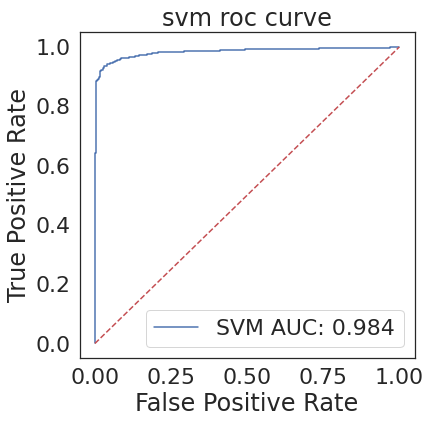

In [64]:
### ROC curve
svc_fpr, svc_tpr, svc_threshold = roc_curve(yTrain, svcPred)
plt.figure(figsize = (6,6))
#plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(yTrain, svcPred)))
plt.plot(svc_fpr, svc_tpr, label='SVM AUC: {:.3f}'.format(roc_auc_score(yTrain, svcPred)))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.title("svm roc curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [65]:
predictTest = clf10.predict(xTest)

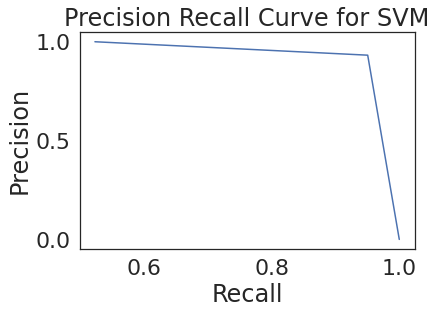

In [66]:
precision, recall, thresholds = precision_recall_curve(yTest, predictTest )

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve for SVM')
plt.show()

In [67]:
## predict with orignal data
predictTest = clf10.predict(xTestBefore)

In [68]:
#print("accuracy: {}".format(round(accuracy_score(yTestBefore, predictTest),4)))
print("precision: {}".format(round(precision_score(yTestBefore, predictTest),4)))
print("recall: {}".format(round(recall_score(yTestBefore, predictTest),4)))

precision: 0.0386
recall: 0.898


In [69]:
from sklearn.metrics import average_precision_score
y_score = clf10.decision_function(xTestBefore)
average_precision = average_precision_score(yTestBefore, y_score)
print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.55


In [70]:
## eleminate some features according to heatmap
creditCardUndersampleXDrop = creditCardUndersample.drop(["Class",'V1','V3','V10','V11','V14','V16', 'V18'],axis = 1)
creditCardUndersampleY = creditCardUndersample['Class']
xTrainDrop,xTestDrop,yTrainDrop, yTestDrop = train_test_split(creditCardUndersampleXDrop, creditCardUndersampleY, test_size=0.2, random_state=0)

In [71]:
## support vector machine
clfDrop1 = svm.SVC(kernel='linear', C=10).fit(xTrainDrop, yTrainDrop)
trainingScoreDrop1 = cross_val_score(clfDrop1, xTrainDrop, yTrainDrop)  ## default is 5 fold
trainingScoreDrop1

array([0.91772152, 0.93037975, 0.89171975, 0.95541401, 0.94904459])

In [72]:
## grid search
parameters = {'kernel':('linear','rbf'), 'C':[0.001,0.1,1, 10, 100]}
svc = svm.SVC()
clfGridSearch = GridSearchCV(svc, parameters)
clfGridSearch.fit(xTrainDrop, yTrainDrop)
GridSearchCV(svc,
             param_grid={'C': [0.001,0.1,1, 10, 100, 1000], 'kernel': ('linear','rbf')},cv=5,scoring='accuracy')
sorted(clfGridSearch.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [73]:
print(clfGridSearch.best_params_)
print()
print('Training accuracy')
print(clfGridSearch.best_score_)
print(clfGridSearch.best_estimator_)

{'C': 10, 'kernel': 'rbf'}

Training accuracy
0.941578650326534
SVC(C=10)


In [74]:
## using RFE to do feature selection,automatic select features
svc = svm.SVC(kernel = 'linear')
rfeSVM = RFECV(estimator = svc)
rfeSVM = rfeSVM.fit(xTrainDrop, yTrainDrop)
pipelineSVM = Pipeline(steps=[('s',rfeSVM),('m',svc)])
# evaluate model
n_scoresSVM= cross_val_score(pipelineSVM, xTrainDrop, yTrainDrop, scoring='accuracy', cv= 5, n_jobs=-1, error_score='raise')
# report performance
print("Accuracy: %0.3f (+/- %0.3f)" % (n_scoresSVM.mean(), n_scoresSVM.std()))

Accuracy: 0.924 (+/- 0.019)


The accuracy did not improve

In [75]:
rfeSVM.ranking_

array([1, 1, 1, 1, 1, 1, 3, 1, 4, 7, 2, 6, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1,
       1])

In [76]:
## using RFE to do feature selection,automatic select features
svc = svm.SVC(kernel = 'linear')
rfeSVM1 = RFECV(estimator = svc)
rfeSVM1 = rfeSVM.fit(xTrain, yTrain)
pipelineSVM1 = Pipeline(steps=[('s',rfeSVM1),('m',svc)])
# evaluate model
n_scoresSVM1 = cross_val_score(pipelineSVM1, xTrain, yTrain, scoring='accuracy', cv= 5, n_jobs=-1, error_score='raise')
# report performance
print("Accuracy: %0.2f (+/- %0.2f)" % (n_scoresSVM1.mean(), n_scoresSVM1.std()))

Accuracy: 0.95 (+/- 0.03)


In [77]:
rfeSVM1.ranking_

array([1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 2, 1, 1, 1,
       1, 1, 5, 1, 1, 3, 1, 1])

In [78]:
rfeSVM.n_features_

25

By RFE feature selection, 10 features are selected.

In [79]:
xTrain.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaledAmount',
       'scaledTime'],
      dtype='object')

In [80]:
xTraindrop2 = xTrain.drop(['V1','V2','V3','V5', 'V6', 'V7','V8','V9', 'V14','V15', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V24', 'V26','V27', 'V28'], axis=1)

In [81]:
## random forest
clfRF = RandomForestClassifier()
clfRF.fit(xTrain, yTrain)
trainingScoreRF= cross_val_score(clfRF, xTrain, yTrain,scoring = "accuracy")  ## default is 5 fold
trainingScoreRF

array([0.96835443, 0.96202532, 0.92993631, 0.95541401, 0.96178344])

In [82]:
## random forest
clfRF = RandomForestClassifier()
clfRF.fit(xTrain, yTrain)
trainingScoreRF= cross_val_score(clfRF, xTrain, yTrain,scoring = "accuracy")  ## default is 5 fold
trainingScoreRF

array([0.96202532, 0.9556962 , 0.92993631, 0.94904459, 0.95541401])

In [83]:
## prediction score
RFPred = cross_val_predict(clfRF, xTrain, yTrain, cv=5)
print(roc_auc_score(yTrain, RFPred))

0.9462479492578575


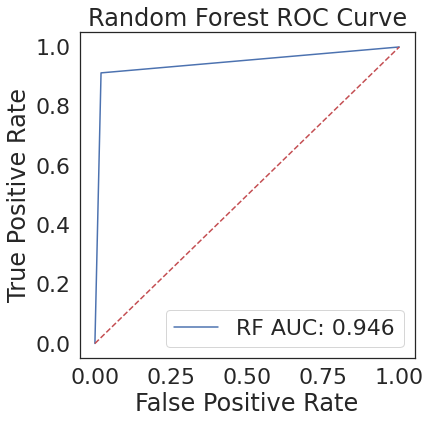

In [84]:
### ROC curve for random forest
rf_fpr, rf_tpr, rf_threshold = roc_curve(yTrain, RFPred)
plt.figure(figsize = (6,6))
plt.plot(rf_fpr, rf_tpr, label='RF AUC: {:.3f}'.format(roc_auc_score(yTrain, RFPred)))
plt.title("Random Forest ROC Curve")
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [106]:
clfRF.feature_importances_

array([0.00802606, 0.03335441, 0.05093021, 0.08565555, 0.00573485,
       0.00658993, 0.02028211, 0.01042654, 0.00869478, 0.12774887,
       0.09324843, 0.1041863 , 0.00718051, 0.15865838, 0.00649296,
       0.0542802 , 0.10068059, 0.02177756, 0.01123884, 0.00980407,
       0.01390623, 0.00566677, 0.0070503 , 0.00598998, 0.00558377,
       0.00707627, 0.00695135, 0.00567844, 0.01181227, 0.00529349])

In [107]:
creditCardUndersampleX.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'scaledAmount',
       'scaledTime'],
      dtype='object')

Text(0.5, 1.0, 'Feature Importance of Random Forest')

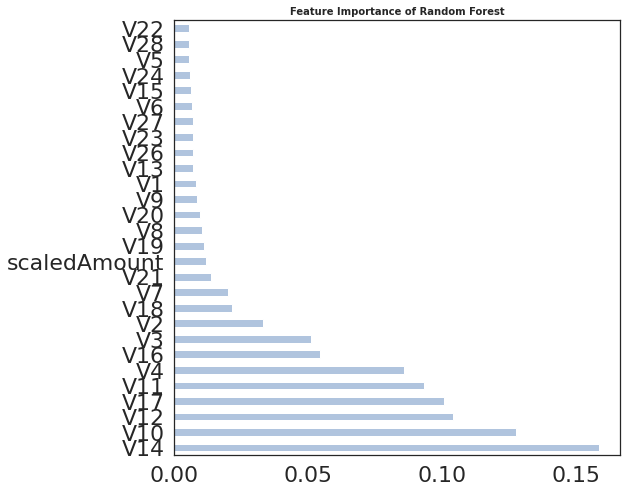

In [108]:
plt.figure(figsize = (8,8))
feat_importances = pd.Series(clfRF.feature_importances_, index=xTrain.columns)
feat_importances.nlargest(28).plot(kind='barh',color = "lightsteelblue")
plt.title("Feature Importance of Random Forest",fontsize = 10, fontWeight = 'bold')

In [109]:
## grid search 
param_grid = {"max_depth": [3,5, None],
              "n_estimators":[3,5,10],
              "max_features": [5,6,7,8]}

# Creating the classifier
model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3, criterion='entropy', n_jobs=1, verbose=1 )
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(xTrain, yTrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=2,
                                              max_features=3, n_estimators=10,
                                              n_jobs=1, random_state=3,
                                              verbose=1),
             param_grid={'max_depth': [3, 5, None],
                         'max_features': [5, 6, 7, 8],
                         'n_estimators': [3, 5, 10]},
             scoring='recall')

In [110]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9132424537487829
{'max_depth': None, 'max_features': 8, 'n_estimators': 5}


In [111]:
## fit the model
rfGridSearch = RandomForestClassifier(max_features = 6, n_estimators = 5)
rfGridSearch.fit(xTrain, yTrain)

RandomForestClassifier(max_features=6, n_estimators=5)

In [112]:
print("Training score data: ")
print(rfGridSearch.score(xTrain, yTrain))

Training score data: 
0.98856416772554


In [113]:
## logistic regression assumption remove highly correlated data
xTrainRemove = xTrain.drop(["V1",'V3','V9','V12','V16'], axis = 1)

In [114]:
## using RFE to do feature selection, keep 20 features
logreg = LogisticRegression()
rfe = RFE(logreg, n_features_to_select=  20)
rfe = rfe.fit(xTrainRemove, yTrain)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True False  True  True  True  True  True  True False
 False  True  True False  True  True False  True  True  True  True  True
  True]
[1 1 1 1 5 1 1 1 1 1 1 2 6 1 1 4 1 1 3 1 1 1 1 1 1]


In [115]:
pipeline = Pipeline(steps=[('s',rfe),('m',logreg)])
# evaluate model
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, xTrain, yTrain, scoring='accuracy', cv= 5, n_jobs=-1, error_score='raise')
# report performance
print("Accuracy: %0.3f (+/- %0.3f)" % (n_scores.mean(), n_scores.std()))

Accuracy: 0.938 (+/- 0.027)


In [116]:
## using RFE to do feature selection, keep 15 features
logreg = LogisticRegression()
rfe1 = RFE(logreg, n_features_to_select  =15)
rfe1 = rfe1.fit(xTrainRemove, yTrain)
print(rfe1.support_)
print(rfe1.ranking_)

[ True  True  True  True False  True  True  True  True  True False False
 False False  True False  True False False  True False  True False  True
  True]
[ 1  1  1  1 10  1  1  1  1  1  3  7 11  6  1  9  1  5  8  1  2  1  4  1
  1]


In [117]:
pipeline1 = Pipeline(steps=[('s',rfe1),('m',logreg)])
# evaluate model
n_scores1 = cross_val_score(pipeline1, xTrain, yTrain, scoring='accuracy', cv= 5, n_jobs=-1, error_score='raise')
# report performance
print("Accuracy: %0.3f (+/- %0.3f)" % (n_scores1.mean(), n_scores1.std()))

Accuracy: 0.944 (+/- 0.024)


In [118]:
## using RFE to do feature selection,automatic select features
logreg = LogisticRegression()
rfe2 = RFECV(estimator=LogisticRegression())
rfe2 = rfe2.fit(xTrain, yTrain)
pipeline2 = Pipeline(steps=[('s',rfe2),('m',logreg)])
# evaluate model
n_scores2= cross_val_score(pipeline2, xTrain, yTrain, scoring='accuracy', cv= 5, n_jobs=-1, error_score='raise')
# report performance
print("Accuracy: %0.3f (+/- %0.3f)" % (n_scores2.mean(), n_scores2.std()))

Accuracy: 0.936 (+/- 0.025)


In [119]:
rfe2.ranking_

array([10, 17,  5,  1, 13, 16,  3,  1, 19,  1,  1,  1,  1,  1, 12,  1,  1,
        9, 18,  6, 14,  1,  1,  4,  2,  1,  7,  8, 15, 11])

In [120]:
xTrainRemove.columns

Index(['V2', 'V4', 'V5', 'V6', 'V7', 'V8', 'V10', 'V11', 'V13', 'V14', 'V15',
       'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28', 'scaledAmount', 'scaledTime'],
      dtype='object')

In [121]:
features = ['V2', 'V4', 'V5', 'V6','V8', 'V10', 'V11', 'V13', 'V14','V18','V21', 'V22', 'V26','V27','scaledTime']

In [122]:
xTrainRemoveRanking = xTrainRemove[features]

In [123]:
LogisticPred = cross_val_predict(rfe2, xTrainRemoveRanking, yTrain, cv=5)
print(roc_auc_score(yTrain, LogisticPred))

0.9375177607274794


In [126]:
from collections import Counter
counter = Counter(ysm_train)
xTrainBefore.shape

(227846, 30)

In [124]:
sm = SMOTE(random_state=2)
xsm_train, ysm_train = sm.fit_sample(xTrainBefore, yTrainBefore.ravel())

In [ ]:
## split the data,test case 80%
#xTrainSm,xTestSm,yTrainSm, yTestSm = train_test_split(xsm_trainDrop, ysm_train, test_size=0.2, random_state=0)  

In [84]:

from collections import Counter
counter = Counter(ysm_train)
xTrainBefore.shape

(227846, 30)

In [85]:
print(counter)

Counter({0: 227452, 1: 227452})


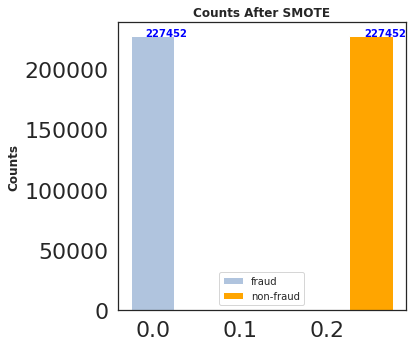

In [86]:
# bar plot of examples by class label
X = np.arange(1)
fig = plt.figure(figsize =(4,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, counter[0], color = 'lightsteelblue', width = 0.05)
ax.bar(X + 0.25, counter[1], color = 'orange', width = 0.05)
ax.set_title("Counts After SMOTE",fontweight = 'bold',fontSize = 12)
ax.text(0-0.008,counter[0]+1,counter[0],color='blue', fontweight='bold', fontSize = 10)
ax.text(0.25-0.008,counter[1]+1,counter[1],color='blue', fontweight='bold', fontSize = 10)
ax.set_ylabel("Counts",fontweight = 'bold',fontSize = 12)
ax.legend(labels = ["fraud", "non-fraud"], fontsize = 10)

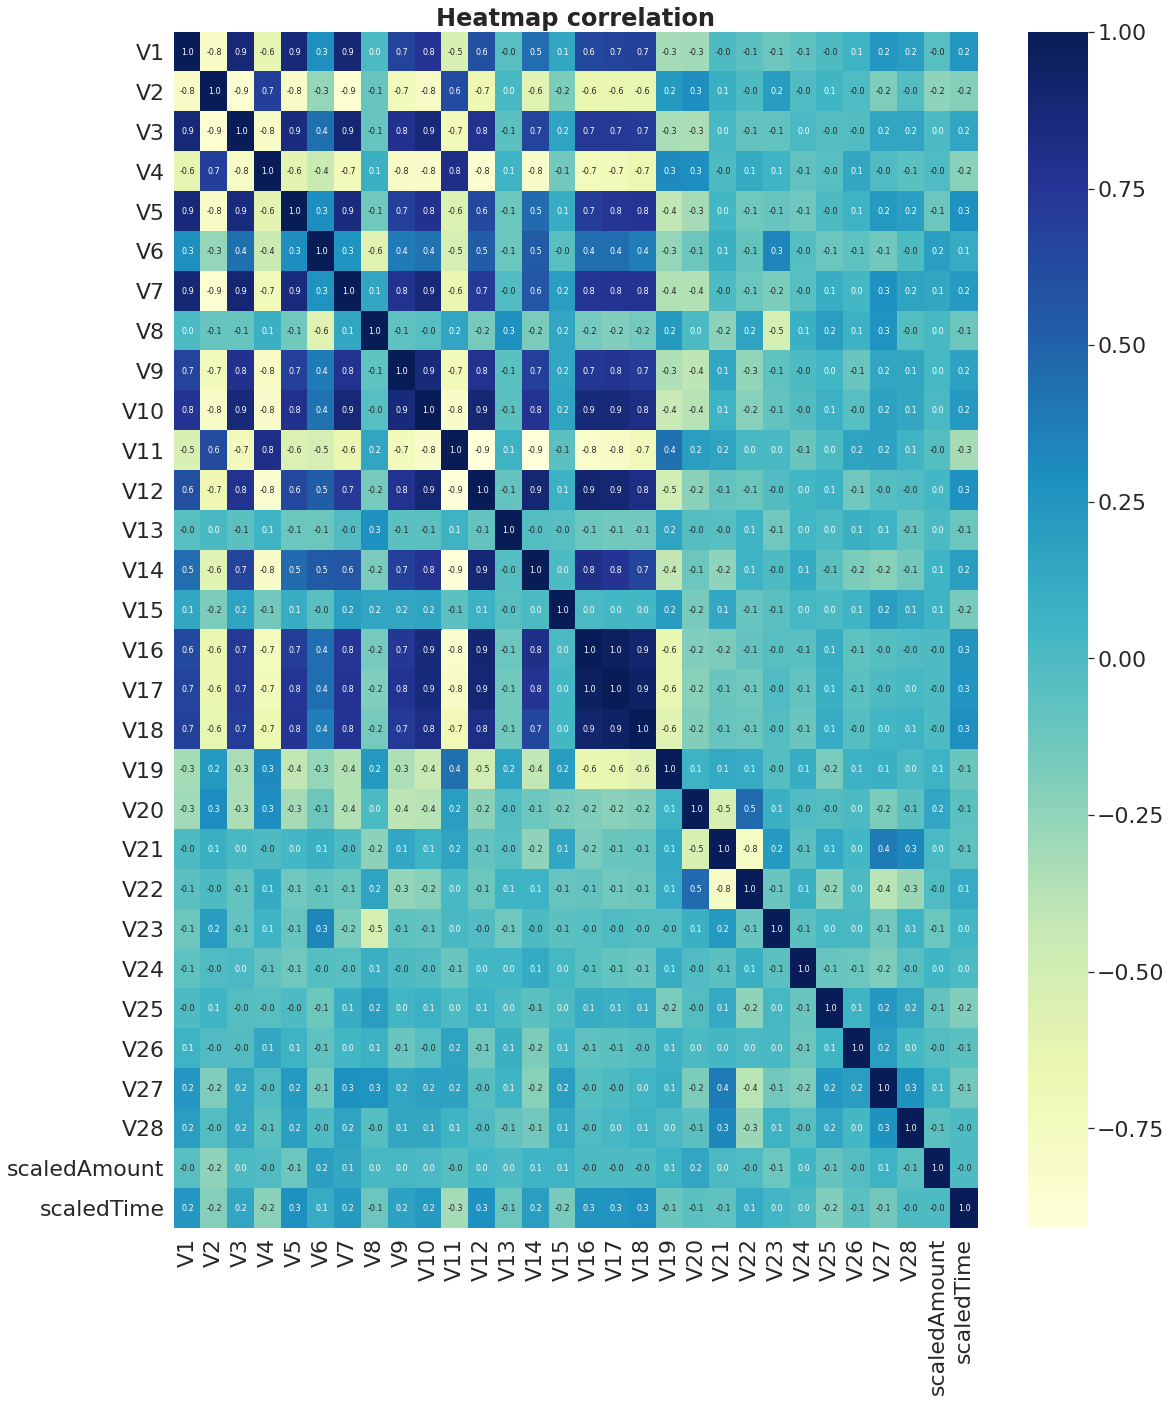

In [87]:
corrOver = xsm_train.corr()

## heatmap
plt.figure(figsize=(18,22))
sns.heatmap(corrOver, cmap="YlGnBu",annot=True,fmt=".1f",annot_kws={'size':8},) # Displaying the Heatmap
sns.set(font_scale=2,style='white')

plt.title('Heatmap correlation',fontWeight = "bold")
plt.show()

- v16,17, and v18 are highly correlated,so we will delete v16,and v18 by keeping v17.
- V1 is highly correlated with v3, v5, v7
- v2 is highly correlated with v3 and v7
- v3 is highly correlated with v1, v2, v5,v7, v10
- v7 and v10 are highly correlated
- v11 and v12 are highly correlated
- so delete v3, v7, v11, v16, v18(V1, V3, V10,V11,V14,V16,V18)

In [88]:
creditCard.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'scaledAmount', 'scaledTime'],
      dtype='object')

In [89]:
xsm_trainDrop = xsm_train.drop(['V3','V7','V11','V16','V18'], axis = 1)

In [90]:
xsm_trainDrop.shape

(454904, 25)

In [91]:
xsm_trainDrop.columns

Index(['V1', 'V2', 'V4', 'V5', 'V6', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14',
       'V15', 'V17', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26',
       'V27', 'V28', 'scaledAmount', 'scaledTime'],
      dtype='object')

In [92]:
## do feature selection


In [93]:
## split the data,test case 80%
xTrainSm,xTestSm,yTrainSm, yTestSm = train_test_split(xsm_trainDrop, ysm_train, test_size=0.2, random_state=0)  

In [94]:
##clfSm = svm.SVC(kernel='linear', C=1).fit(xTrainSm, yTrainSm)

In [95]:
parameters = {
    'C': [ 0.1, 1, 10, 100]
             }
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, cv=5, verbose=5, n_jobs=3)
clf.fit(xTrainSm, yTrainSm.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   12.5s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:   20.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done  20 out of  20 | elapsed:   20.0s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=3,
             param_grid={'C': [0.1, 1, 10, 100]}, verbose=5)

In [96]:
clf.best_estimator_

LogisticRegression(C=10)

In [97]:
prediction = best_est.predict(xTrainSm)

NameError: name 'best_est' is not defined

In [98]:
lr1 = LogisticRegression(C= 100, verbose=5)
lr1.fit(xTrainSm, yTrainSm)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished


LogisticRegression(C=100, verbose=5)

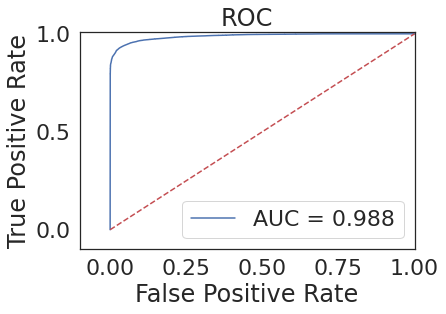

In [107]:
y_pred_sample_score = lr1.decision_function(xTestSm)


fpr, tpr, thresholds = roc_curve(yTestSm, y_pred_sample_score)

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [100]:
roc_auc

0.9876521303930458

In [108]:
fpr

array([0.        , 0.        , 0.        , ..., 0.99367033, 0.99371414,
       1.        ])

No handles with labels found to put in legend.


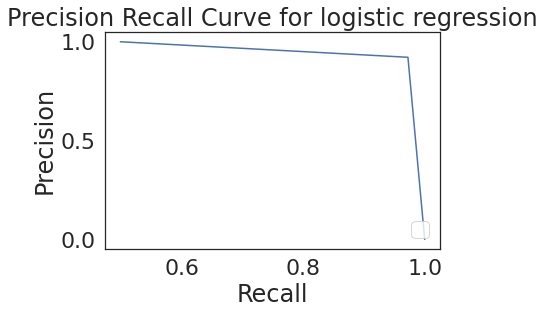

In [101]:
predictTest = lr1.predict(xTestSm)
precision, recall, thresholds = precision_recall_curve(yTestSm, predictTest )

# Plot ROC curve
plt.plot(precision, recall)
plt.legend(loc='lower right')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve for logistic regression')
plt.show()